## ANN classifier

In [94]:
import torch
import torch.nn as nn
import torch.optim as optim #Parameter optimization functions
import numpy as np
import random #Random shuffling
import matplotlib.pyplot as plt
from numpy import ma
from scipy.io import loadmat #Loading data
from sklearn.model_selection import train_test_split #Train/test data split.

In [95]:
#loadData function
def loadData(name):
    return(loadmat(name))

In [96]:
#Displays a image (one slice of input)
def showImage(img):
    img = img.reshape((20,20))
    img = np.transpose(img) #The dataset has the values transposed somehow?
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(img)
    

In [97]:
#Selects and shows a random image from X and prints it's corresponding label.
def showRandImage(X, y):
    index = np.random.randint(X.shape[0])
    img = X[index, :]
    print("The value is ", y[index])
    showImage(img)

In [98]:
#Unison shuffle. Reference from https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [99]:
#Load the data. 
data = loadData("ex3data1.mat")
X = data["X"]
y = data["y"][:,0]
X = X.reshape(5000,20,20)
X = np.transpose(X,(0,1,2)) #Testing transpose
X = X.reshape(5000,400)
X, y = unison_shuffled_copies(X,y)
print("Input shape: ", X.shape)
print("Output shape: ", y.shape)

Input shape:  (5000, 400)
Output shape:  (5000,)


The value is  4


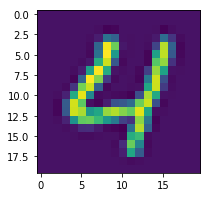

In [100]:
#Show one of our input data and label.
showRandImage(X, y)

As we see, the data we are given are images with the class label 1-10 corresponding to the value.

In [101]:
#Define the neural net.
class ANN(nn.Module):
    
    def __init__(self):
        #Define the network
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(400, 25)
        self.fc2 = nn.Linear(25,10)
        self.Sigmoid = nn.Sigmoid()
        self.Softmax = nn.Softmax(dim = -1)

    def forward(self, x):
        x = self.Sigmoid(self.fc1(x))
        x = self.Softmax(self.fc2(x))
        return(x)
    
    def loadWeight(self, weights):
        fc1 = torch.from_numpy(weights["Theta1"][:,:-1]).float()
        fc1Bias = torch.from_numpy(weights["Theta1"][:,0]).float()
        fc2 = torch.from_numpy(weights["Theta2"][:,:-1]).float()
        fc2Bias = torch.from_numpy(weights["Theta2"][:,0]).float()
        
        print(fc1.shape)
        print(fc1Bias)
        print(fc2Bias)
        
        param = list(self.parameters())
        param[0].data.sub_(fc1)
        param[1].data.sub_(fc1Bias)
        param[2].data.sub_(fc2)
        param[3].data.sub_(fc2Bias)


In [102]:
#Evaluate the network
def evaluate(model, X, y):
    dataSize = len(X[:,1]) #Total number of samples.
    #Test on the dataset
    #For each of the featureset.
    samples = list(range(dataSize))
    random.shuffle(samples)
    correct = 0

    with torch.no_grad():
        for i in samples:
            features = torch.from_numpy(X[i]).float()
            #Extract the correct value
            target = torch.zeros((10))
            target[y[i]-1] = 1.0
            #Predict
            outputs = model(features)
            _, predicted = torch.max(outputs, 0)
            correct += (int(predicted) == y[i]-1)

    return(100*correct/dataSize)

### Train the Network

In [103]:
#Initialize the neural net
classifier = ANN()
print(classifier)
#Create the optim
optimizer = optim.SGD(classifier.parameters(), lr=0.2)

ANN(
  (fc1): Linear(in_features=400, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=10, bias=True)
  (Sigmoid): Sigmoid()
  (Softmax): Softmax()
)


In [36]:
#Before training the accuracy is 10%. 
print("Accuracy%: ", evaluate(classifier, X, y))

Accuracy%:  10.0


In [12]:
def train(classifier, X,y, epochSize = 20 ):
    #Split into test and train.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    #Training.
    dataSize = len(X_train[:,1]) #Total number of samples.
    #Store the result here to plot graph.
    AccuracyCount = []
    LossCount = []
    for epoch in range(0,20):
        losses = []
        accuracyCount = []
        correctCount = 0
        #For each of the featureset.
        samples = list(range(dataSize))
        random.shuffle(samples)
        
        for i in samples:
            #Train with SGD for each set. |
            optimizer.zero_grad()   # zero the gradient
            #Extract a feature i
            features = torch.from_numpy(X_train[i]).float()
            #Extract the correct value
            target = torch.zeros((10))
            target[y_train[i]-1] = 1.0
            #Define the MSE loss.
            output = classifier(features)
            loss = nn.MSELoss()(output, target)
            #Backprop the loss to each node.
            loss.backward()
            #Updates our weights using optim SGD.
            optimizer.step()
            #Keep track of loss and accuracy.
            losses.append(loss)
        losses = np.array(losses, dtype=float)
        accuracy = evaluate(classifier, X_test, y_test)
        AccuracyCount.append(accuracy)
        mean = np.mean(losses)
        LossCount.append(mean)
        #Print every 2 epochs
        if epoch % 2 == 0:
            print("Epoch:"+ str(epoch) + " Avg MSE Loss:", mean, "Ave Accuracy%: ", accuracy)
    return(AccuracyCount, LossCount)

In [13]:
AccuracyCount, LossCount = train(classifier, X, y)

Epoch:0 Avg MSE Loss: 0.08790641761996916 Ave Accuracy%:  32.6
Epoch:2 Avg MSE Loss: 0.044822139894822616 Ave Accuracy%:  80.6
Epoch:4 Avg MSE Loss: 0.02168073146518145 Ave Accuracy%:  88.4
Epoch:6 Avg MSE Loss: 0.01581413760944182 Ave Accuracy%:  90.13333333333334
Epoch:8 Avg MSE Loss: 0.013233651425943046 Ave Accuracy%:  90.26666666666667
Epoch:10 Avg MSE Loss: 0.011557868127880257 Ave Accuracy%:  90.6
Epoch:12 Avg MSE Loss: 0.01045044438119567 Ave Accuracy%:  91.2
Epoch:14 Avg MSE Loss: 0.009554697682844327 Ave Accuracy%:  91.06666666666666
Epoch:16 Avg MSE Loss: 0.008746758259271572 Ave Accuracy%:  91.8
Epoch:18 Avg MSE Loss: 0.008039895962044779 Ave Accuracy%:  91.8


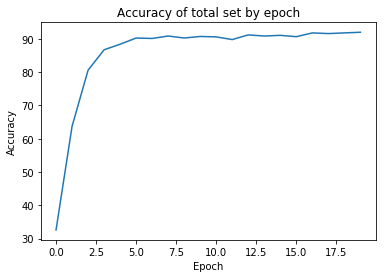

In [14]:
#Plot the accuracy gain
plt.plot(AccuracyCount)
plt.title('Accuracy of total set by epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

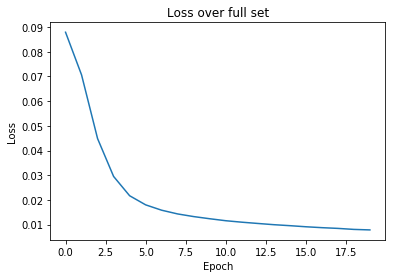

In [15]:
#Plot the loss rate
#Plot the accuracy gain
plt.plot(LossCount)
plt.title('Loss over full set')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

### Loading some pre-trained weights

We load some pre-trained weights and see if it help our training process.

In [64]:
#Clear and load our weights
weights = loadData("ex3weights.mat")
classifier.loadWeight(weights)

torch.Size([25, 400])
tensor([-0.0226, -0.0984,  0.1162, -0.2397, -0.7316, -0.5979,  0.1546, -0.0337,
        -0.4107,  0.0235,  0.2477,  0.2653,  0.0943,  0.2022, -0.2030,  0.1046,
         0.1489, -0.0379, -0.3320, -0.2977, -0.4842, -0.3898, -0.1832, -0.7021,
        -0.3509])
tensor([-0.7610, -0.6179, -0.6893, -0.6783, -0.5966, -0.8779, -0.5275, -0.7490,
        -0.6665, -0.4609])


In [17]:
print("Accuracy%: ", evaluate(classifier, X, y))

Accuracy%:  30.56


We can see immideatly the accuracy is at >10% of the whole dataset. There are features in the weights which helps our training as well. Nevertheless, are difference between the strategy of the loaded weights and my network's weights. (Perhaps the inputs to the loaded data are normalized). 

In [18]:
AccuracyCount, LossCount = train(classifier, X, y)

Epoch:0 Avg MSE Loss: 0.04190098093484234 Ave Accuracy%:  85.66666666666667
Epoch:2 Avg MSE Loss: 0.01243026934519431 Ave Accuracy%:  89.13333333333334
Epoch:4 Avg MSE Loss: 0.009455683382851224 Ave Accuracy%:  91.0
Epoch:6 Avg MSE Loss: 0.008044274450050525 Ave Accuracy%:  91.26666666666667
Epoch:8 Avg MSE Loss: 0.006999641488646761 Ave Accuracy%:  92.13333333333334
Epoch:10 Avg MSE Loss: 0.006242087409258876 Ave Accuracy%:  92.06666666666666
Epoch:12 Avg MSE Loss: 0.005658483857514207 Ave Accuracy%:  91.73333333333333
Epoch:14 Avg MSE Loss: 0.005210543816991699 Ave Accuracy%:  92.0
Epoch:16 Avg MSE Loss: 0.004780754725622301 Ave Accuracy%:  91.73333333333333
Epoch:18 Avg MSE Loss: 0.004440892073698323 Ave Accuracy%:  91.73333333333333


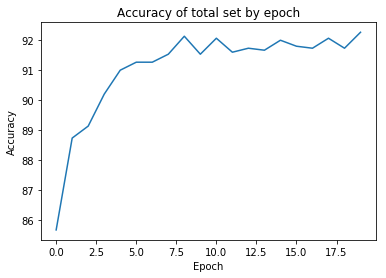

In [19]:
#Plot the accuracy gain
plt.plot(AccuracyCount)
plt.title('Accuracy of total set by epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

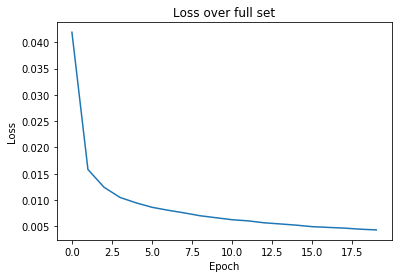

In [20]:
#Plot the loss rate
#Plot the accuracy gain
plt.plot(LossCount)
plt.title('Loss over full set')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

It appears that using the pretrained feature weights helped our model to train faster especially initially

### Predicting with regularized logistic regression strategy (One vs Many)

■ Compare the performance of the Neural Network and a Regularized
Logistic regression module (One-vs-all strategy) for multi-class

In [167]:
from sklearn.linear_model import LogisticRegression

In [177]:
#Normalize data
X_scaled = scale(X, axis=1) #We normalize our inputs using the difference to mean / std dev

In [178]:
#Test train split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [ ]:
#Create our regularized logistic regression classifier.
classifier = LogisticRegression(solver='lbfgs',max_iter=100000, multi_class='ovr', penalty='l2').fit(X_train, y_train)

In [179]:
#Calculate the accuracy
classifier.score(X_test, y_test)

0.888